In [1]:
import sys
!{sys.executable} -m pip install colossus
!{sys.executable} -m pip install emcee
!{sys.executable} -m pip install corner

In [2]:
import numpy as np
import scipy
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
from scipy.optimize import curve_fit

import emcee
import corner

mpl.rcParams['agg.path.chunksize'] = 10000  # This is required to correctly plot the mass function evaluated on the data array



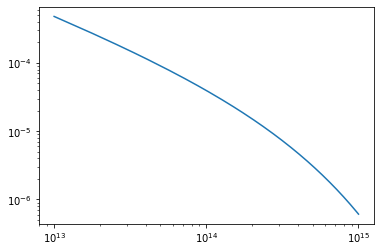

In [3]:

## cosmology.setCosmology('WMAP9') This is a default cosmology

params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.048254, 'sigma8': 0.81, 'ns': 0.96} # This sets a customized cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

# Array of masses
m_arr = np.linspace(1E13,1E15,128)

##for mass in m_arr:
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM') # q_out modifies the output function
##    mfunc_fof = mass_function.massFunction(mass, 0.0, mdef = 'fof', model = 'watson13', q_out = dndlnM))
plt.loglog(m_arr,  mfunc_so)


plt.show()   

In [4]:
a = np.load('converted_catalog_z0.000_mock0001.npz') # Import the catalog and read through it
print(a.files)
print(a['mass'].shape) # a['masss] is an array with 2772758 components
print(a['mass'].shape)
print(np.max(a['mass']))
print(len(a['mass']))
print(np.max(a['pos']))

print(np.log10(np.e))
BoxVolume = np.amax(a['pos'])**3.

print(BoxVolume)

['mass', 'pos']
(2772758,)
(2772758,)
5705458771838476.0
2772758
3869.9985
0.4342944819032518
57960537183.56983


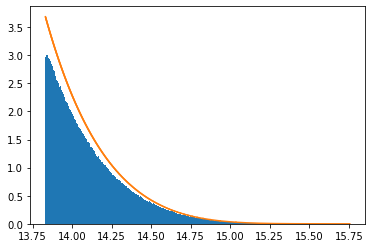

In [22]:
xmin = np.min(a['mass'])
xmax = np.max(a['mass'])
plt.hist(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ) , density = True )#Histogram of log-mass catalog, density=True gives a normalized histogram


m_arr = a['mass']
m_arr.sort() # order by increasing value
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')

plt.plot(np.log10(m_arr), BoxVolume*(1e-6)*mfunc_so) 
plt.show()

[50.22823274  0.30463044  0.8       ]


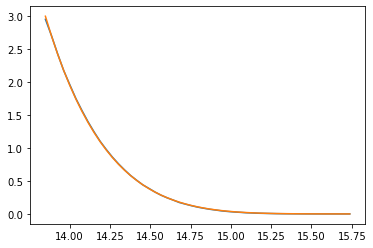

In [23]:
bin_heights, bin_borders = np.histogram(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ), density = True)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

# Let us perform a preliminary fit
def func(x, a1, a2, a3):
    params = {'flat': True, 'H0': a1, 'Om0': a2, 'Ob0': 0.049,'sigma8': a3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume*(1e-6)*mass_function.massFunction(x, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata = 10**(bin_centers)
ydata = bin_heights

popt, pcov = curve_fit(func, xdata, ydata, p0=[67., 0.3, 0.8], bounds=([50., 0.1, 0.1],[75, 0.5, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata), ydata)
plt.plot(np.log10(xdata), func(xdata, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

In [24]:
# Let us write the Likelihood function

def massfunction(theta, mass):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so = np.array(BoxVolume*(1e-6)*mass_function.massFunction(mass, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so

def log_prior(theta):
    Om0, sigma8 = theta
    if 0.1 < Om0 < 1.0 and 0.1 < sigma8 < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, mass, ydata):
    #err = DM_err What do I use as error array?
    mfunc_so = massfunction(theta, mass)
    logl = np.sum(ydata*np.log(mfunc_so)- mfunc_so)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl

def log_posterior(theta, mass, ydata):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(theta, mass, ydata)
    logpos = logl+lp
    return logpos


In [25]:
theta = [0.3,0.3]
print(log_likelihood(theta, xdata, ydata))
print(massfunction(theta, xdata))
 
      
theta = [0.1,0.3]
print(log_likelihood(theta, xdata, ydata))
print(massfunction(theta, xdata))

-214.96134952083787
[7.30120526e-03 5.10647974e-03 3.52509527e-03 2.40014185e-03
 1.61063111e-03 1.06440077e-03 6.92149935e-04 4.42481243e-04
 2.77830100e-04 1.71166284e-04 1.03359252e-04 6.11056719e-05
 3.53258526e-05 1.99447069e-05 1.09823715e-05 5.88938376e-06
 3.07100241e-06 1.55458701e-06 7.62633817e-07 3.61888735e-07
 1.65779396e-07 7.31583375e-08 3.10309331e-08 1.26205318e-08
 4.90900699e-09 1.82117159e-09 6.42515092e-10 2.14901226e-10
 6.79160908e-11 2.02087841e-11 5.64013833e-12 1.47046439e-12
 3.56568991e-13 8.00446987e-14 1.65521122e-14 3.13605143e-15
 5.41292516e-16 8.45921837e-17 1.18908814e-17 1.49282985e-18
 1.66119224e-19 1.62517304e-20 1.38561519e-21 1.01989915e-22
 6.41569334e-24 3.41168357e-25 1.51579035e-26 5.55611152e-28
 1.65751583e-29 3.96583717e-31 7.49103305e-33]
-362.6923927620619
[2.47941009e-05 1.69001953e-05 1.14139860e-05 7.63580115e-06
 5.05834401e-06 3.31710061e-06 2.15258628e-06 1.38186022e-06
 8.77230976e-07 5.50489760e-07 3.41352744e-07 2.09081425e-07

In [29]:
pos = [0.5,0.8] + 1e-2 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata, ydata))
sampler.run_mcmc(pos, 1000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [43:00<00:00,  2.58s/it]


State([[0.32026158 0.73366643]
 [0.337179   0.78092514]
 [0.2570845  0.95349072]
 [0.25177998 0.8493609 ]
 [0.3245278  0.82196075]
 [0.31371575 0.93970419]
 [0.26245986 0.87962615]
 [0.4757937  0.6627787 ]
 [0.36727899 0.67052438]
 [0.26844816 0.81760458]
 [0.25076135 0.78404719]
 [0.4029549  0.68275998]
 [0.33347524 0.76127644]
 [0.33022292 0.71189736]
 [0.20593659 0.93355888]
 [0.25679256 0.81647669]], log_prob=[-18.93590466 -19.4583806  -19.18956481 -18.91997725 -19.71902618
 -21.77509318 -18.80754955 -22.64169756 -19.23649378 -18.86078842
 -19.91929285 -19.80345078 -19.09707609 -19.04793445 -19.61537944
 -19.10574193], blobs=None, random_state=('MT19937', array([2444691553, 2914055550,   22597897,  131394318, 1811135052,
       1404269690,  885705655, 1071036723, 3506583898,  106612986,
       3352960595, 1507585367,   78410432, 2981638858, 2375907151,
       1153020727, 3557922233, 1283243064, 2122994796,  898707983,
        291969495, 3718493880,  369386517, 1375550240, 381215500

(1000, 16, 2)


Text(0.5, 0, 'step number')

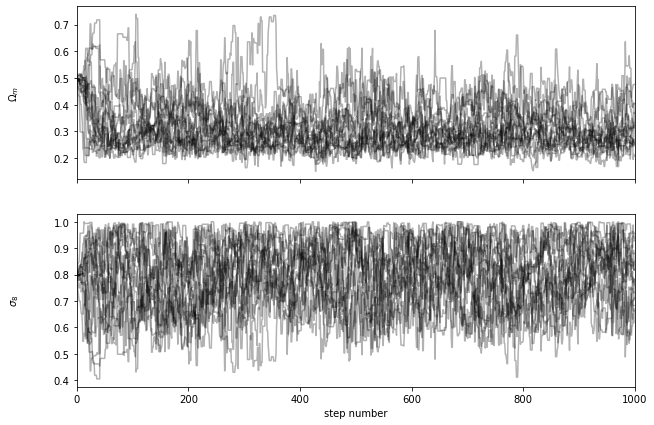

In [32]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["$\Omega_{m}$", "$\sigma_{8}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

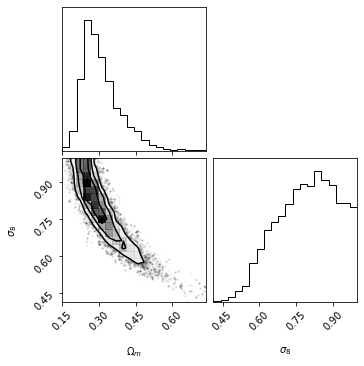

In [33]:
flat_samples = sampler.get_chain(discard=100, flat=True)

fig = corner.corner(flat_samples, labels=labels)